In [35]:
import pandas as pd

from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report


In [43]:
train_dataset = pd.read_json('./dataset/train_data.jsonl')
val_dataset = pd.read_json('./dataset/val_data.jsonl')
test_dataset = pd.read_json('./dataset/test_data.jsonl')

In [48]:
X_train = train_dataset['text']
y_train = train_dataset['positive']
X_val = val_dataset['text']
y_val = val_dataset['positive']
X_test = test_dataset['text']
y_test = test_dataset['positive']

# Naive Bayes
1. Use CountVectorizer(unigram)

In [49]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)

In [50]:
MNB = MultinomialNB()

MNB.fit(X_train, y_train)

MultinomialNB()

In [51]:
y_pred = MNB.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred))

Accuracy: 90.48%
              precision    recall  f1-score   support

           0       0.65      0.53      0.58     25695
           1       0.93      0.96      0.95    180163

    accuracy                           0.90    205858
   macro avg       0.79      0.74      0.76    205858
weighted avg       0.90      0.90      0.90    205858



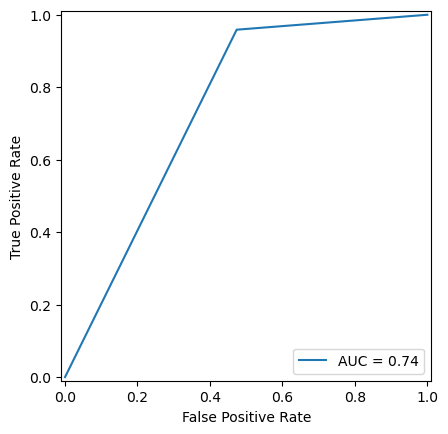

In [52]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
roc_plot = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_plot.plot()

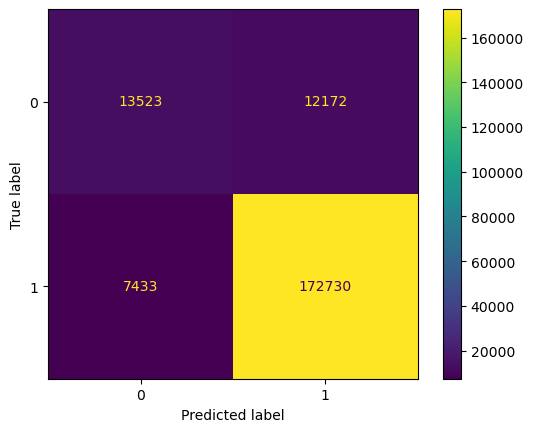

In [53]:
cm = confusion_matrix(y_test, y_pred)
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_plot.plot()

# References
- Data: https://amazon-reviews-2023.github.io/data_loading/jsonl.html
- https://www.kaggle.com/code/mehmetisik/amazon-reviews-boosting-sales-sentiment-analysis
- https://github.com/reasonmii/project-toxic-comment-classification/blob/main/Yuna-Supervised/Toxic-Classification.ipynb
- https://www.kaggle.com/code/ankumagawa/sentimental-analysis-using-naive-bayes-classifier